In [1]:
#!pip install openpyxl

In [2]:
#Import
import pandas as pd
import numpy as np
import scipy
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#Display two point cloud with different colours in one o3d window
def display_three_pointclouds(array_1,array_2,array_3,windowname):
    p1_pcd = o3d.geometry.PointCloud()
    p1_pcd.points = o3d.utility.Vector3dVector(array_1)
    p1_pcd.paint_uniform_color([0, 0, 0])


    p2_pcd = o3d.geometry.PointCloud()
    p2_pcd.points = o3d.utility.Vector3dVector(array_2)
    p2_pcd.paint_uniform_color([38/255, 191/255, 214/255])

    p3_pcd = o3d.geometry.PointCloud()
    p3_pcd.points = o3d.utility.Vector3dVector(array_3)
    p3_pcd.paint_uniform_color([140/225, 76/255, 164/225]) 
    
    
    concate_pc = np.concatenate((array_1, array_2,array_3),axis = 0)
    p1_color = np.asarray(p1_pcd.colors)
    p2_color = np.asarray(p2_pcd.colors)
    p3_color = np.asarray(p3_pcd.colors)
    p4_color = np.concatenate((p1_color,p2_color,p3_color), axis=0)

    p4_pcd = o3d.geometry.PointCloud()
    p4_pcd.points = o3d.utility.Vector3dVector(concate_pc)
    p4_pcd.colors = o3d.utility.Vector3dVector(p4_color)
    o3d.visualization.draw_geometries([p4_pcd],window_name = windowname)

In [4]:
def display_two_pointclouds(array_1,array_2,windowname):
    
    p1_pcd = o3d.geometry.PointCloud()
    p1_pcd.points = o3d.utility.Vector3dVector(array_1)
    p1_pcd.paint_uniform_color([1, 0.706, 0])


    p2_pcd = o3d.geometry.PointCloud()
    p2_pcd.points = o3d.utility.Vector3dVector(array_2)
    p2_pcd.paint_uniform_color([0, 0.706, 1])

    
    concate_pc = np.concatenate((array_1, array_2),axis = 0)
    p1_color = np.asarray(p1_pcd.colors)
    p2_color = np.asarray(p2_pcd.colors)

    p4_color = np.concatenate((p1_color,p2_color), axis=0)

    p4_pcd = o3d.geometry.PointCloud()
    p4_pcd.points = o3d.utility.Vector3dVector(concate_pc)
    p4_pcd.colors = o3d.utility.Vector3dVector(p4_color)
    o3d.visualization.draw_geometries([p4_pcd],window_name = windowname)

The purpose of this function is to take a vessel and determine at which axial distance at which another vessel branches off. Additionally it needs to check to see what the terminus condition of the vessel is and then create the appropriate ending conditions for it whether that be flowing directly into another vessel (continous), branching into multiple vessels (split) or no end condition in which case we will need to apply the 0D end condition (tree).

Our first necessary step will be to import the excel file which contains all of the file names and the links between them

In [5]:
#Import Excel Sheets
try:
    arteries_sheet = pd.read_excel('C:\\Users\\Cassidy.Northway\\GitRemoteRepo\\FlowTracker.xlsx', sheet_name = 0)
    veins_sheet = pd.read_excel('C:\\Users\\Cassidy.Northway\\GitRemoteRepo\\FlowTracker.xlsx', sheet_name = 1)
except:
    arteries_sheet = pd.read_excel('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\FlowTracker.xlsx', sheet_name = 0)
    veins_sheet = pd.read_excel('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\FlowTracker.xlsx', sheet_name = 1)
    

In [6]:
#Select sheet
sheet = arteries_sheet
#sheet = veins_sheet

In [7]:
#Define our data frame
df = pd.DataFrame(columns=['Name','Centre Axis Array', 'Radius Array','End Condition'])


In [8]:
#Now we need to define our 
location = 0

#Look at every vessel in the sheet
for index in range(52,65):#range(0,sheet.shape[0]):551,

    name = sheet.at[index,'Anatomy Name']
    file_name = sheet.at[index,'Filename']
    
    #Determine whether the vessel branches at all
    end_point = sheet.at[index,'End Point']

    if pd.isna(end_point):
        final_condition = 'LW' #indicating that the end condition will be the Lax Wendroff
    else:
        #If the branches exist then we need to process the 
        final_condition = end_point.split(',')
        final_condition = [s.strip() for s in final_condition]
    
    #Does the vessel branch (other than the end condition?)
    branches = sheet.at[index,'Out Flow']
    
    if pd.isna(branches):
        segement_tag  = False
    else:
        segement_tag = True
        branches = branches.split(',')
        branches = [s.strip() for s in branches]
        
        #Remove end condition branches 
        if final_condition != 'LW':
            for vessels in final_condition:
                branches.remove(vessels)

    #If there are no segements then we just save the whole thing
    if segement_tag == False:
        main_branch_filename = file_name + '_fitted_data.npy'
    
        try:
            main_branch_array = np.load('C:\\Users\\Cassidy.Northway\\GitRemoteRepo\\FittedVesselsFiles\\' + main_branch_filename)
        except:
            main_branch_array = np.load('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\FittedVesselsFiles\\' + main_branch_filename)
        
        sub_name =  name + '_0'   
        center_sub_array = main_branch_array[:,0:3 ]
        radius_array = main_branch_array[:,3 ]
        end_condition = final_condition
        new_row_seg = {'Name' : sub_name,'Centre Axis Array': center_sub_array, 'Radius Array' : radius_array,'End Condition' : end_condition }
        df.loc[len(df)] = new_row_seg
                
    #If the vessel does segement now we gotta set spicy and determine where it segements for each vessel and which comes first
    if segement_tag == True:
        seg_df = pd.DataFrame(columns=['Branch Name','Index of Split'])
        sub_index = 0
        
        #Find the file names of the main and branches
        main_branch_filename = file_name + '_fitted_data.npy'
        branch_filenames = []

        #For each of the branching files determine the file name to load in the gile
        for i in range(0,len(branches)):
            branch_name = branches[i]
            try:
                vessel_row = sheet[sheet['Anatomy Name'].str.match(branch_name)].index.values[0]
            except:
                print(sheet[sheet['Anatomy Name'].str.match(branch_name)].index.values, branch_name)
                    
            branch_filename = sheet.at[sheet.index[vessel_row],'Filename']
            branch_filename = branch_filename + '_fitted_data.npy'
            branch_filenames.append(branch_filename)

        #Now we import all of the vessel file
        try:
            main_branch_array = np.load('C:\\Users\\Cassidy.Northway\\GitRemoteRepo\\FittedVesselsFiles\\' + main_branch_filename)
        except:
            main_branch_array = np.load('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\FittedVesselsFiles\\' + main_branch_filename)

        for i in range(0,len(branches)):
            branch_filename = branch_filenames[i]
            branch_name = branches[i]
        
            try:
                branch_array = np.load('C:\\Users\\Cassidy.Northway\\GitRemoteRepo\\FittedVesselsFiles\\' + branch_filename)
            except:
                branch_array = np.load('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\FittedVesselsFiles\\' + branch_filename)

            #display_two_pointclouds(main_branch_array[:,0:3],branch_array[:,0:3], branch_name)
            
            #Find the nearest points
            dist_array = scipy.spatial.distance.cdist(main_branch_array[:,0:3],branch_array[:,0:3])
            dist_array = dist_array[:,0]
            index_split = np.where (np.min(dist_array) == dist_array)[0]
            seg_df.loc[len(seg_df)] = {'Branch Name': branch_name , 'Index of Split': index_split[0]}
        
        #We now have the number of off branching vessels and where they branch so now we need to now save the 
        #segements and off branches and sort segment frame by distance along vessel

        seg_df = seg_df.sort_values(by ='Index of Split')
        seg_df = seg_df.reset_index(drop=True)
        intial_index = 0


        for i in range(0,len(seg_df)+1):
            if i != len(seg_df):
                sub_name =  name + '_' + str(i)
                final_index = seg_df.at [ i , 'Index of Split']
                center_sub_array = main_branch_array[intial_index:final_index+1,0:3 ]
                radius_array = main_branch_array[intial_index:final_index,3 ]
                
                #p4_pcd = o3d.geometry.PointCloud()
                #p4_pcd.points = o3d.utility.Vector3dVector(center_sub_array)
                #o3d.visualization.draw_geometries([p4_pcd])
                
                end_condition = [name + '_' + str(i+1), branches[i]+'_0' ]
                new_row_seg = {'Name' : sub_name,'Centre Axis Array': center_sub_array, 'Radius Array' : radius_array,'End Condition' : end_condition }
                if not radius_array.any():
                    print(new_row_seg
                df.loc[len(df)] = new_row_seg
                intial_index = final_index
                
            else:
                sub_name =  name + '_' + str(i)
                final_index = -1
                center_sub_array = main_branch_array[intial_index:final_index,0:3 ]
                radius_array = main_branch_array[intial_index:final_index,3 ]
                
                #p4_pcd = o3d.geometry.PointCloud()
                #p4_pcd.points = o3d.utility.Vector3dVector(center_sub_array)
                #o3d.visualization.draw_geometries([p4_pcd])
                
                if not radius_array.any():
                    print(new_row_seg)
                if final_condition != 'LW':
                    end_condition = [final_condition[0] +'_0']
                else:
                    end_condition = final_condition
                new_row_seg = {'Name' : sub_name,'Centre Axis Array': center_sub_array, 'Radius Array' : radius_array,'End Condition' : end_condition }
                df.loc[len(df)] = new_row_seg
print(df)    

                 Name                                  Centre Axis Array  \
0    arteries_larm0_0  [[315.4633415682742, 25.954324485566556, -203....   
1    arteries_larm1_0  [[309.19313180904646, 20.706282542645546, -128...   
2    arteries_larm1_1  [[313.28198708429795, 12.156050518405742, -151...   
3   left_arm_artery_0  [[116.65202964922126, -8.668835668277834, 359....   
4   left_arm_artery_1  [[205.63173169711672, 16.24416647260944, 262.5...   
5   left_arm_artery_2  [[217.2603418170059, 29.825598800907834, 196.4...   
6   left_arm_artery_3  [[256.2588396751025, 35.13315691546923, 85.639...   
7    arteries_larm3_0  [[317.44173048669904, 11.78355787413251, -208....   
8    arteries_larm5_0  [[205.40863149037415, 15.895767753638536, 262....   
9    arteries_larm6_0  [[302.9636126272466, -4.875191423685981, -118....   
10   arteries_larm6_1  [[312.6509245025052, -17.815586755093726, -176...   
11   arteries_larm6_2  [[317.73357336992837, 11.513579955257038, -208...   
12   arterie

## Reassess end conditions

We want to go through rows and change the end condition from the name of the vessel segement to the index of those vessels

In [9]:
#If any vessels end with a single split then I want to combine them into a single vessel before altering 
#everybodies index number
removal_indices=[]
for i in range (0,len(df)):
    end_condition = df.at[i,'End Condition']
    if end_condition != 'LW' and len(end_condition)==1:
        index = df[df['Name']==end_condition[0]].index[0]
        name = df.at[i,'Name']
        centre_array = np.append(df.at[i,'Centre Axis Array'],df.at[index,'Centre Axis Array'],axis = 0)
        radius_array = np.append(df.at[i,'Radius Array'],df.at[index,'Radius Array'],axis = 0)
        new_end_condition = df.at[index,'End Condition']
        new_row_seg = {'Name' : name,'Centre Axis Array': centre_array, 'Radius Array' : radius_array,'End Condition' : new_end_condition }
        df.loc[len(df)] = new_row_seg
        removal_indices.append(i)
        removal_indices.append(index)
        

print(removal_indices)

df = df.drop(df.index[removal_indices])
df = df.reset_index(drop=True)
display(df)




[6, 9]


,Name,Centre Axis Array,Radius Array,End Condition
0,arteries_larm0_0,"[[315.4633415682742, 25.954324485566556, -203....","[0.4328404293460279, 0.4328383909305353, 0.432...",LW
1,arteries_larm1_0,"[[309.19313180904646, 20.706282542645546, -128...","[0.853673155595933, 0.8536663311833349, 0.8536...","[arteries_larm1_1, arteries_larm13_0]"
2,arteries_larm1_1,"[[313.28198708429795, 12.156050518405742, -151...","[0.8105117387427757, 0.8098031392343058, 0.809...",LW
3,left_arm_artery_0,"[[116.65202964922126, -8.668835668277834, 359....","[2.464436819046319, 2.464438928920124, 2.46444...","[left_arm_artery_1, arteries_larm10_0]"
4,left_arm_artery_1,"[[205.63173169711672, 16.24416647260944, 262.5...","[2.466101393313841, 2.465677211818813, 2.46524...","[left_arm_artery_2, arteries_larm5_0]"
5,left_arm_artery_2,"[[217.2603418170059, 29.825598800907834, 196.4...","[2.3741895451537554, 2.373087475490786, 2.3719...","[left_arm_artery_3, arteries_larm9_0]"
6,arteries_larm3_0,"[[317.44173048669904, 11.78355787413251, -208....","[0.5483312756355074, 0.548330248261935, 0.5483...",LW
7,arteries_larm5_0,"[[205.40863149037415, 15.895767753638536, 262....","[1.7249317512387006, 1.7249281545501427, 1.724...",LW
8,arteries_larm6_1,"[[312.6509245025052, -17.815586755093726, -176...","[0.7026524325473806, 0.7026387162889902, 0.702...","[arteries_larm6_2, arteries_larm3_0]"
9,arteries_larm6_2,"[[317.73357336992837, 11.513579955257038, -208...","[0.6940895203832484, 0.6939894356403382, 0.693...",LW


In [10]:
#df.to_pickle('larm.pkl')

In [11]:
display(df)

,Name,Centre Axis Array,Radius Array,End Condition
0,arteries_larm0_0,"[[315.4633415682742, 25.954324485566556, -203....","[0.4328404293460279, 0.4328383909305353, 0.432...",LW
1,arteries_larm1_0,"[[309.19313180904646, 20.706282542645546, -128...","[0.853673155595933, 0.8536663311833349, 0.8536...","[arteries_larm1_1, arteries_larm13_0]"
2,arteries_larm1_1,"[[313.28198708429795, 12.156050518405742, -151...","[0.8105117387427757, 0.8098031392343058, 0.809...",LW
3,left_arm_artery_0,"[[116.65202964922126, -8.668835668277834, 359....","[2.464436819046319, 2.464438928920124, 2.46444...","[left_arm_artery_1, arteries_larm10_0]"
4,left_arm_artery_1,"[[205.63173169711672, 16.24416647260944, 262.5...","[2.466101393313841, 2.465677211818813, 2.46524...","[left_arm_artery_2, arteries_larm5_0]"
5,left_arm_artery_2,"[[217.2603418170059, 29.825598800907834, 196.4...","[2.3741895451537554, 2.373087475490786, 2.3719...","[left_arm_artery_3, arteries_larm9_0]"
6,arteries_larm3_0,"[[317.44173048669904, 11.78355787413251, -208....","[0.5483312756355074, 0.548330248261935, 0.5483...",LW
7,arteries_larm5_0,"[[205.40863149037415, 15.895767753638536, 262....","[1.7249317512387006, 1.7249281545501427, 1.724...",LW
8,arteries_larm6_1,"[[312.6509245025052, -17.815586755093726, -176...","[0.7026524325473806, 0.7026387162889902, 0.702...","[arteries_larm6_2, arteries_larm3_0]"
9,arteries_larm6_2,"[[317.73357336992837, 11.513579955257038, -208...","[0.6940895203832484, 0.6939894356403382, 0.693...",LW


In [12]:
#Trouble shooting 

#array_1 = main_branch_array[0:50,0:3 ]
#array_2 = main_branch_array[51:125,0:3 ]
#array_3 = main_branch_array[126:-1,0:3 ]
#display_three_pointclouds(array_1,array_2,array_3,'Troubleshoot')

display_three_pointclouds(df.at[1,'Centre Axis Array'],df.at[2,'Centre Axis Array'],df.at[20,'Centre Axis Array'],'blarg')


#p4_pcd = o3d.geometry.PointCloud()
#p4_pcd.points = o3d.utility.Vector3dVector(main_branch_array[0:50,0:3 ])
#o3d.visualization.draw_geometries([p4_pcd])

In [13]:
#print(main_branch_array[:,0:3])

### From here below we will convert the database to be useful for VamPy. Central axis array will become lam = L/Ru, radius array = [Ru,Rd], add we will add k values 

In [14]:
#Define our data frame
df_vampy = pd.DataFrame(columns=['Name','lam', 'Radius Values','End Condition','k Array'])

#Percentile of radius values used to determine Ru and Rd
percent = 0.05 #5%

In [15]:
for i in range(0,len(df)):
    name = df.at[i,'Name']
    end_condition = df.at[i, 'End Condition']
    
    #Determine the radius values
    radius_values = df.at[i, 'Radius Array']
    index_rounding= np.round(len(radius_values)*percent).astype(int)+1
    Ru = np.mean(radius_values[0:index_rounding])
    
    Rd = np.mean(radius_values[-index_rounding:-1])
    radius_array = [Ru, Rd]
    
    #Determine total distance of the vessel
    centeral_axis_array = df.at[i,'Centre Axis Array']
    total_distance = 0
    
    for j in range(0,np.shape(centeral_axis_array)[0]-1):
        dist = np.linalg.norm(centeral_axis_array[j,:] - centeral_axis_array[j+1,:])
        total_distance = total_distance + dist
    lam_value = total_distance / Ru 
    
    #Determine the k values (using parameters from 2015_Maynards):
    if 'pulmonary' in name:
        k_values = [1.3e6, -7, 12.2e4]
    elif Ru < 3: #less than 0.3 cm ak 3mm
        k_values = [20e6, -22.5, 86.5e4]
    else:
        k_values = [3e6, -9, 33.7e4]
        
        
    
    
    #Write the new row
    new_row_seg = {'Name' : name,'lam': lam_value, 'Radius Values' : radius_array,'End Condition' : end_condition, 'k Array' : k_values }           
    df_vampy.loc[len(df_vampy)] = new_row_seg
                
display(df_vampy)    

,Name,lam,Radius Values,End Condition,k Array
0,arteries_larm0_0,160.010445,"[0.4324711956417675, 0.2515404289567611]",LW,"[20000000.0, -22.5, 865000.0]"
1,arteries_larm1_0,31.638385,"[0.8536185611143791, 0.8136343454800824]","[arteries_larm1_1, arteries_larm13_0]","[20000000.0, -22.5, 865000.0]"
2,arteries_larm1_1,140.603290,"[0.8042822622246099, 0.5672535944085138]",LW,"[20000000.0, -22.5, 865000.0]"
3,left_arm_artery_0,61.353495,"[2.4645152678836904, 2.4694367259901004]","[left_arm_artery_1, arteries_larm10_0]","[20000000.0, -22.5, 865000.0]"
4,left_arm_artery_1,27.881877,"[2.4648008079098322, 2.379078644901464]","[left_arm_artery_2, arteries_larm5_0]","[20000000.0, -22.5, 865000.0]"
5,left_arm_artery_2,50.534481,"[2.3680370156268844, 2.0594221595418554]","[left_arm_artery_3, arteries_larm9_0]","[20000000.0, -22.5, 865000.0]"
6,arteries_larm3_0,191.349018,"[0.5479836185836771, 0.272030729677001]",LW,"[20000000.0, -22.5, 865000.0]"
7,arteries_larm5_0,142.137416,"[1.7244286672964946, 1.457373008912477]",LW,"[20000000.0, -22.5, 865000.0]"
8,arteries_larm6_1,77.201663,"[0.7025590365972576, 0.6948922894689221]","[arteries_larm6_2, arteries_larm3_0]","[20000000.0, -22.5, 865000.0]"
9,arteries_larm6_2,127.384227,"[0.6927332024144819, 0.5576951242201819]",LW,"[20000000.0, -22.5, 865000.0]"


In [16]:
#df_vampy.to_pickle('larm.pkl')

## Time to reorder the vessels to actually descend in order of "depth"




In [17]:
df_ordered = pd.DataFrame(columns=['Name','lam', 'Radius Values','End Condition','k Array'])

#FOR LARM

index_0 = 3

In [18]:
#Save first vessel
df_ordered.loc[0]=df_vampy.loc[index_0]
next_layer = df_ordered.at[0,'End Condition']
while len(next_layer)>0:
    next_layer_1 = []
    for daughter in next_layer:
        index = df_vampy[df_vampy['Name']==daughter].index.values[0]
        df_ordered.loc[len(df_ordered)] = df_vampy.loc[index]
        end_condition = df_vampy.at[index, 'End Condition']
        
        if end_condition !='LW':
            
            next_layer_1 = np.append(next_layer_1, end_condition)
        next_layer = next_layer_1


In [19]:
#Rename everyhting by index#

for i in range (0,len(df_ordered)):
    end_condition = df_ordered.at[i,'End Condition']
    if end_condition != 'LW':
        replacement = []
        if isinstance(end_condition[0], str): 
            for j in range(0,len(end_condition)):
                condition = end_condition[j]
                try: 
                    index = df_ordered[df_ordered['Name']==condition].index.values[0]
                except:
                    print(condition)
                    
                replacement.append(index)
            df_ordered.at[i,'End Condition'] = replacement 
            
display(df_ordered)

,Name,lam,Radius Values,End Condition,k Array
0,left_arm_artery_0,61.353495,"[2.4645152678836904, 2.4694367259901004]","[1, 2]","[20000000.0, -22.5, 865000.0]"
1,left_arm_artery_1,27.881877,"[2.4648008079098322, 2.379078644901464]","[3, 4]","[20000000.0, -22.5, 865000.0]"
2,arteries_larm10_0,16.133096,"[1.6847346298082457, 1.6605002633391708]","[5, 6]","[20000000.0, -22.5, 865000.0]"
3,left_arm_artery_2,50.534481,"[2.3680370156268844, 2.0594221595418554]","[7, 8]","[20000000.0, -22.5, 865000.0]"
4,arteries_larm5_0,142.137416,"[1.7244286672964946, 1.457373008912477]",LW,"[20000000.0, -22.5, 865000.0]"
5,arteries_larm10_1,136.723963,"[1.6493228784148273, 1.0172302426085267]","[9, 10]","[20000000.0, -22.5, 865000.0]"
6,arteries_larm12_0,131.119871,"[0.8647722234034264, 0.8546506549209344]",LW,"[20000000.0, -22.5, 865000.0]"
7,left_arm_artery_3,161.198843,"[2.0178393240923236, 0.7030087130025718]","[11, 12]","[20000000.0, -22.5, 865000.0]"
8,arteries_larm9_0,103.804623,"[1.540918881405833, 1.310833785581163]",LW,"[20000000.0, -22.5, 865000.0]"
9,arteries_larm10_2,42.78139,"[0.9996807553281728, 0.905561715773071]","[13, 14]","[20000000.0, -22.5, 865000.0]"


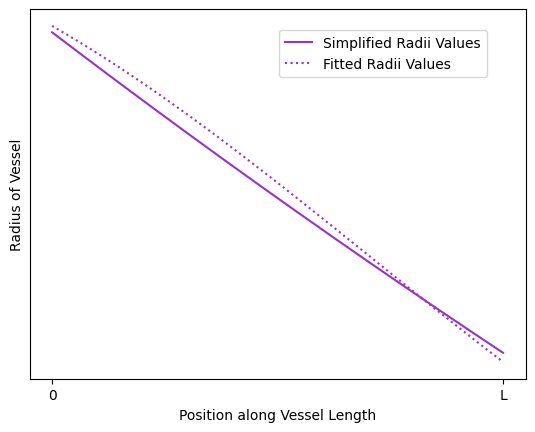

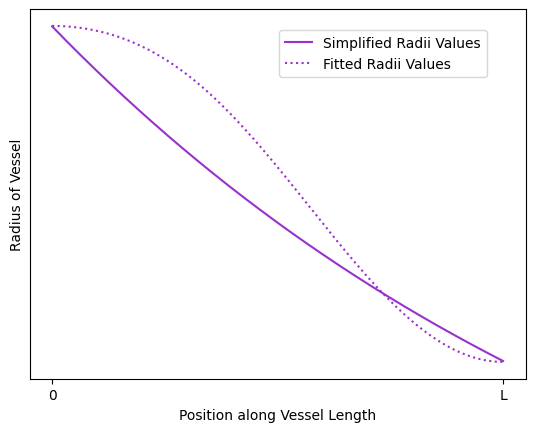

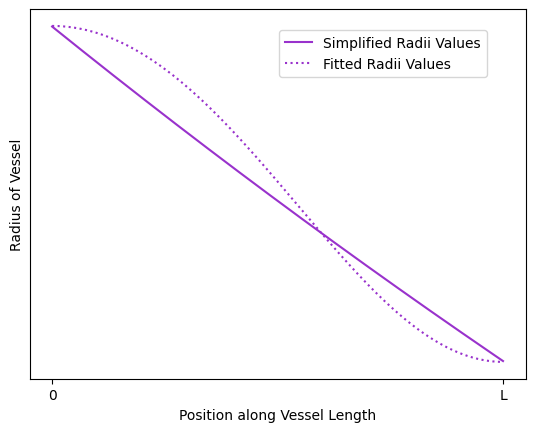

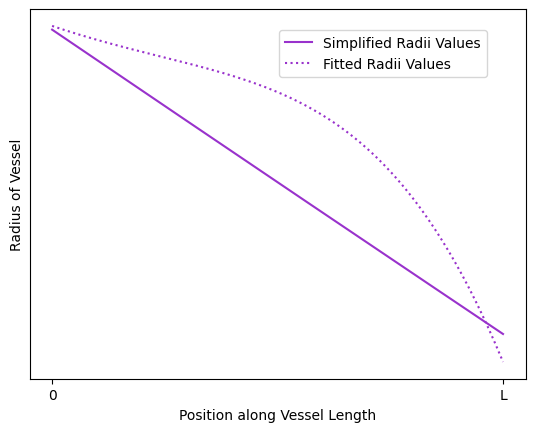

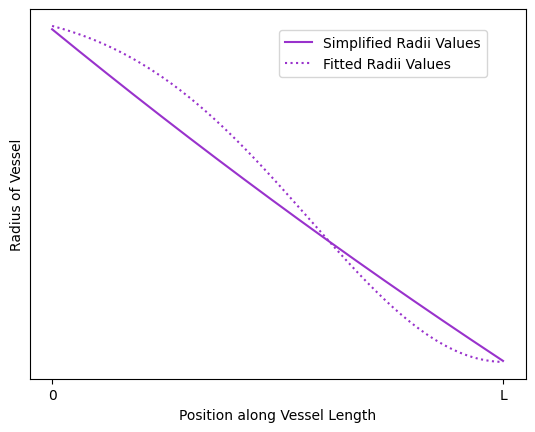

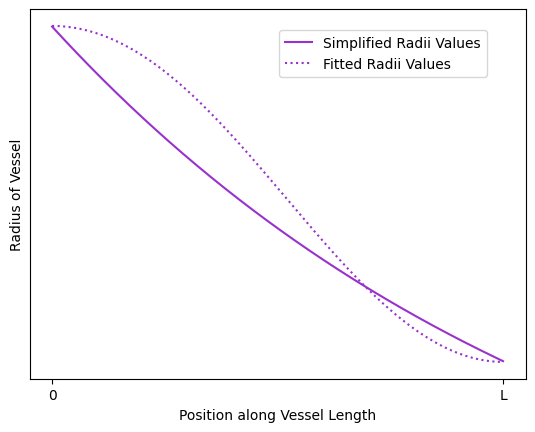

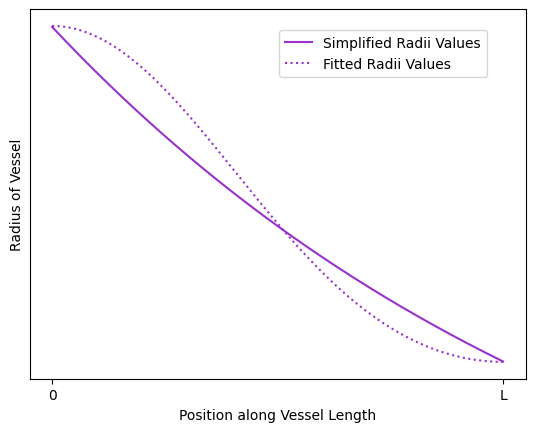

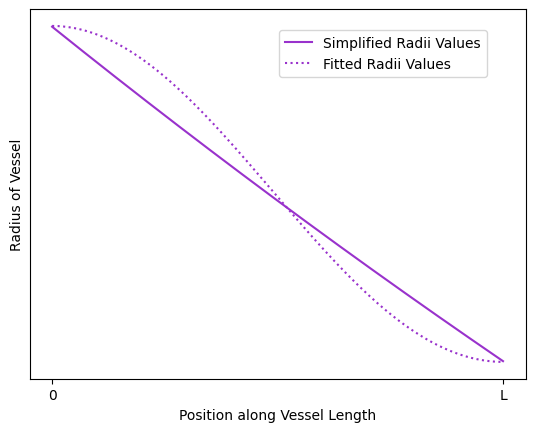

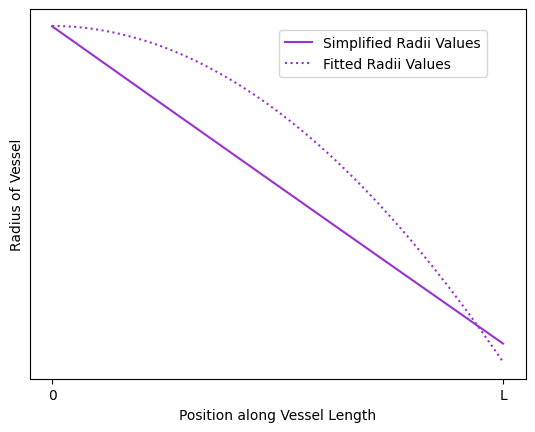

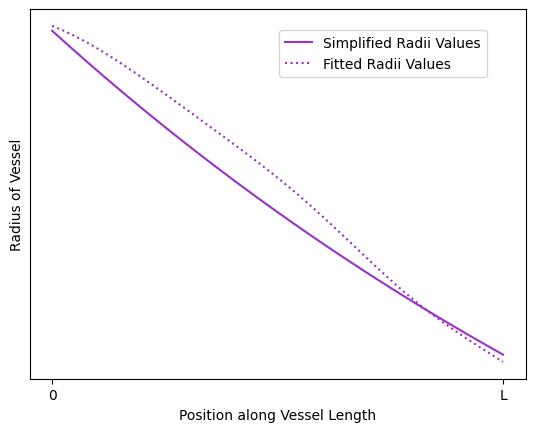

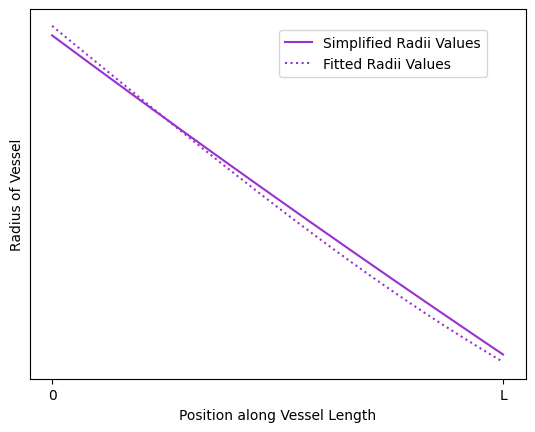

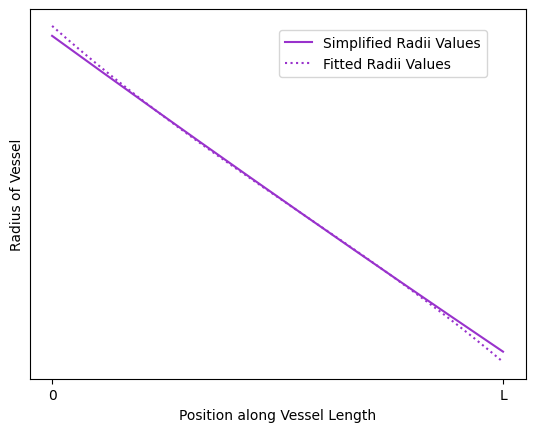

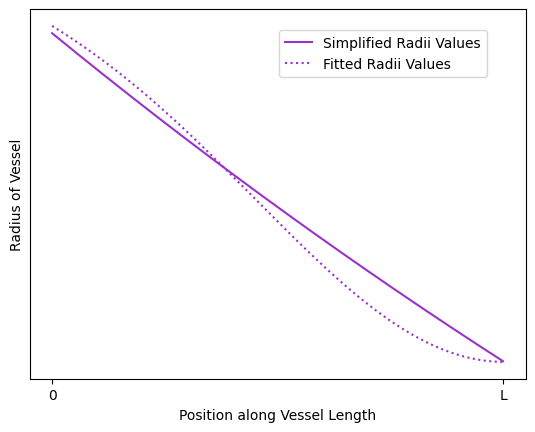

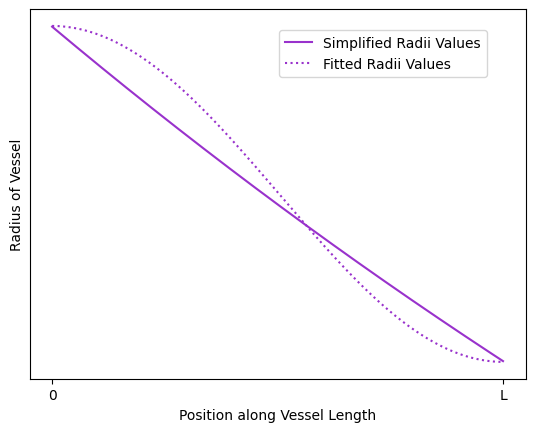

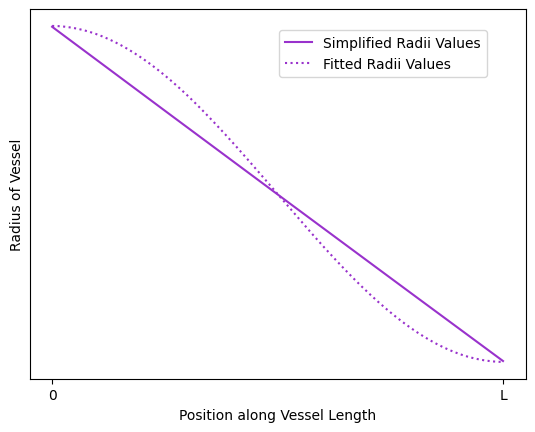

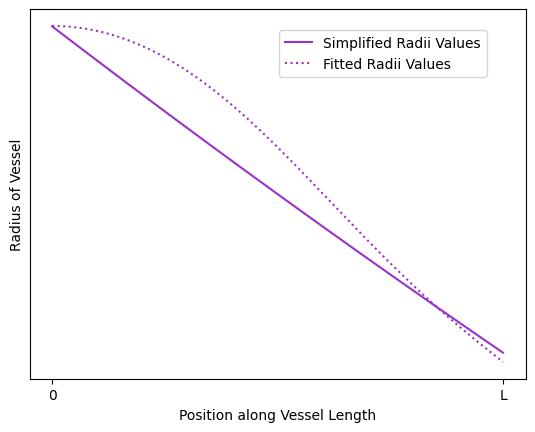

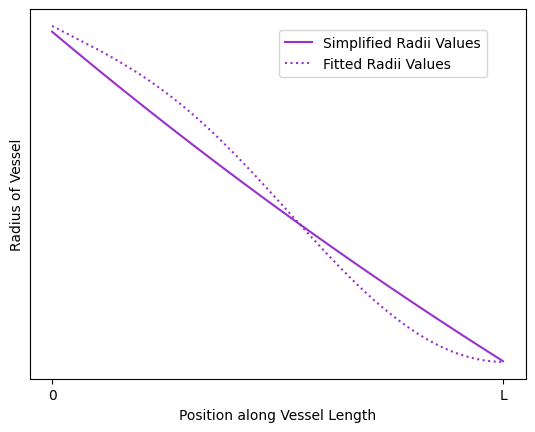

In [20]:
#df_ordered.to_pickle('larm.pkl')
for i in range(5,22):
    radiusArray = df.loc[i, 'Radius Array']
    nx = np.shape(radiusArray)[0]
    lam = df_vampy.loc[i, 'lam']
    radiusValues = df_vampy.loc[i,'Radius Values']
    Ru = radiusValues[0]
    Rd = radiusValues[1]
    L = lam * Ru
    X = np.linspace(0,L,nx)
    R = Ru * np.power((Rd/Ru),X/L)
    R =Ru*np.exp(j*np.log(Rd/Ru)*(X/L))
    
    plt.figure()
    plt.plot(X,R, label = "Simplified Radii Values", c = 'darkorchid')
    plt.plot(X, radiusArray, label = 'Fitted Radii Values', c = 'darkorchid', ls = 'dotted')
    plt.figlegend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
    labels = [None]*len(X)
    labels[0] = 0
    labels[-1] = 'L'


    plt.xticks(ticks = [0,L], labels = [0,'L'])
    plt.yticks([],[])
    plt.xlabel('Position along Vessel Length')
    plt.ylabel('Radius of Vessel')

    
    

    
